# NLP Project

Kaggle competition "Real or Not? NLP with Disaster Tweets". We'll use the (leaked) test labels only to evaluate our model in the end.  
First we import some standard packages and read the data.

In [76]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
train = pd.read_csv("train.csv", index_col='id')
test = pd.read_csv("test.csv", index_col='id')

The training data is roughly balanced.

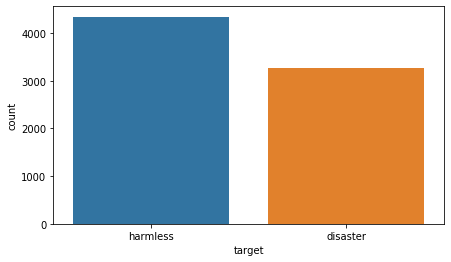

In [78]:
plt.figure(figsize=(7,4))
sns.countplot(x=train.target)
plt.xticks([0,1], ['harmless', 'disaster']);

Let's check for null entries:

In [79]:
train.info(), test.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(1), object(3)
memory usage: 617.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 10875
Data columns (total 4 columns):
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
target      3263 non-null int64
dtypes: int64(1), object(3)
memory usage: 127.5+ KB


The location column has a lot of null entries, so we're not going to use it. To preprocess the text data, we can do the following:
- add the keyword as first word of the text
- remove all urls by dropping everything that starts with 'http'
- replace '%20' by blank and '&amp' by 'and'
- drop all non-alphabetic characters like numbers and punctuation
- use a tweet tokenizer to drop #-handles, convert to lowercase, and reduce to at most three identitcal letters in a row
- stem and remove stopwords

All of the above is done by the function clean(data). After cleaning, a few tweets will become identical, so we drop duplicates. 

In [80]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords = stopwords.words('english')
ps = PorterStemmer()

def clean(data):
    df=data.copy()
    df['keyword'].fillna('', inplace=True)
    df['keyword'] = df['keyword'].str.replace('%20', ' ')
    df['text'] = df['keyword']+' '+df['text']
    df['text'] = df['text'].str.replace(r'http\S+', ' ')
    df['text'] = df['text'].str.replace('&amp', ' and ')
    df['text'] = df['text'].str.replace(r'[^a-zA-Z]', ' ')
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
    df['text'] = df['text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
    return df

df=clean(train)
df = df.drop_duplicates(subset='text')
X = df['text']
y = df['target']

X_test = clean(test)['text']
y_test = test['target']

Now the tweets look like this: 

In [93]:
X

id
1                deed reason earthquak may allah forgiv us
4                     forest fire near la rong sask canada
5        resid ask shelter place notifi offic evacu she...
6              peopl receiv wildfir evacu order california
7        got sent photo rubi alaska smoke wildfir pour ...
                               ...                        
10869       two giant crane hold bridg collaps nearbi home
10870    aria ahrari thetawniest control wild fire cali...
10871                                utc km volcano hawaii
10872    polic investig e bike collid car littl portug ...
10873    latest home raze northern california wildfir a...
Name: text, Length: 6870, dtype: object

Next we'd like to keep track of word appearances. For this, we count how often a word occurs in a harmless or disastrous tweet and store the count in a new dataframe wordcount. 



In [82]:
from collections import defaultdict

freq_dict_1 = defaultdict(int)
for row in df['text'][df['target']==1]:
    for word in row.split():
        freq_dict_1[word] += 1
        
freq_dict_0 = defaultdict(int)
for row in df['text'][df['target']==0]:
    for word in row.split():
        freq_dict_0[word] += 1 
        
vocabulary = set(freq_dict_0.keys()).union(set(freq_dict_1.keys()))

wordcount = pd.DataFrame(list(vocabulary), columns= ["word"])
wordcount['disaster'] = wordcount['word'].apply(lambda x: freq_dict_1[x])
wordcount['harmless'] = wordcount['word'].apply(lambda x: freq_dict_0[x])
wordcount['total_count'] = wordcount['disaster']+wordcount['harmless']
wordcount.sort_values(by='total_count', ascending=False, inplace=True)
wordcount.set_index('word', inplace=True)


In [83]:
wordcount

,disaster,harmless,total_count
word,,,
fire,402,141,543
like,100,298,398
bomb,242,96,338
burn,147,169,316
emerg,143,159,302
...,...,...,...
etern,0,1,1
crackedgem,0,1,1
johnfugelsang,1,0,1


Let's see what the most frequent words in harmless vs. disaster tweets are.

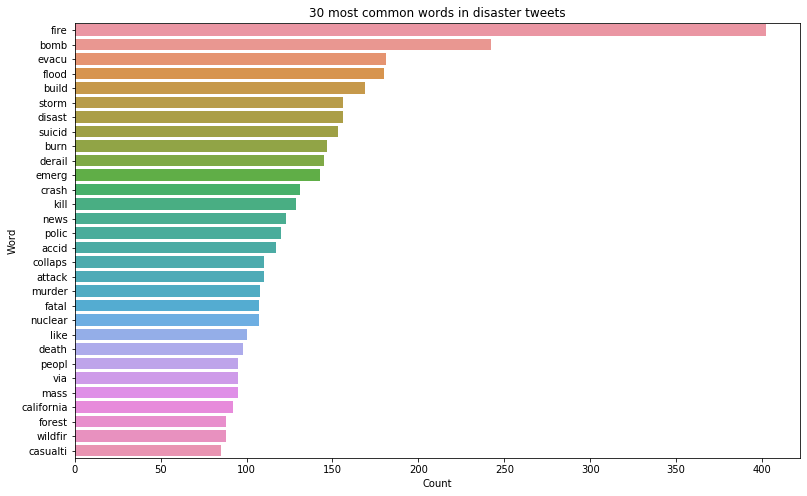

In [84]:
plt.figure(figsize=(13,8))
sns.barplot(x=wordcount['disaster'].sort_values(ascending=False).iloc[:30], y=wordcount.sort_values(by='disaster', ascending=False).index[:30])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('30 most common words in disaster tweets');

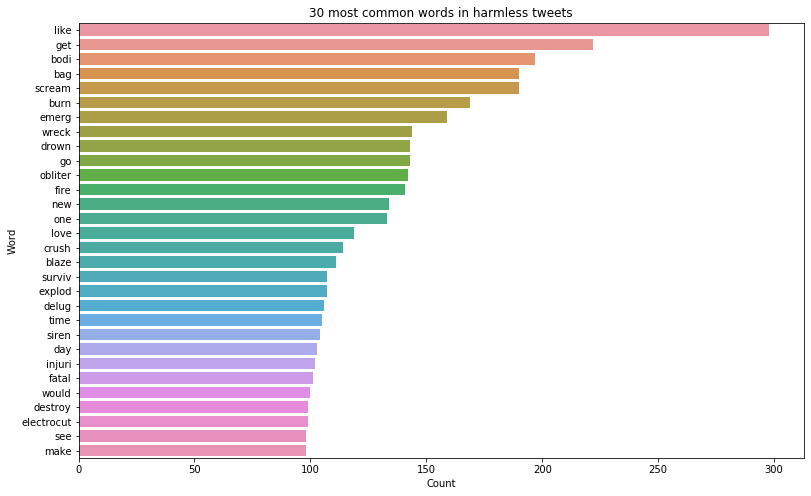

In [85]:
plt.figure(figsize=(13,8))
sns.barplot(x=wordcount['harmless'].sort_values(ascending=False).iloc[:30], y=wordcount.sort_values(by='harmless', ascending=False).index[:30])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('30 most common words in harmless tweets');

Then we remove all words that occur less than 5 times in total from the tweets. Some tweets will become empty strings, so we drop these from X and y and update the vocabulary.

In [7]:
minimal_occurrences = 10
X=X.apply(lambda x: ' '.join([word for word in x.split() if wordcount['total_count'][word]>=minimal_occurrences]))
X=X[X.str.split().apply(len)>0]
y=y[X.index]
wordcount = wordcount[wordcount['total_count']>=minimal_occurrences]
new_vocabulary = set(wordcount.index)


Let's see how many words we've dropped.

In [8]:
print('Length of old vocabulary: {}'.format(len(vocabulary)))
print('Length of new vocabulary: {}'.format(len(new_vocabulary)))

Length of old vocabulary: 16068
Length of new vocabulary: 1285


It's time to vectorize. We first use the count vectorizer, which encodes each tweet as a vector, where the entry at each word is the number of occurrences of this word in the tweet. We can do the same for the tf-idf (term frequency * inverse document frequency) vectorizer, which normalizes the counts by the total number of tweets in which the word occurs. 

We can also adjust the n-gram range to include entries for tuples of words. For example, ngram_range=(1,2) considers words and pairs of words.

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(ngram_range=(1,2))
#vectorizer = TfidfVectorizer(ngram_range=(1,1))

train_vectors = vectorizer.fit_transform(X)
test_vectors = vectorizer.transform(X_test)

Now we split the data into a train and validation set. Since the vectors are sparse matrices, we won't apply scaling. 

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_vectors, y, test_size=0.2, shuffle=True, stratify=y)

Having vectorized the tweets, we can project the vectors down to two dimensions using singular value decomposition (SVD). 
We plot the two-dimensional projections of harmless tweets as yellow dots and of disaster tweets as red dots. Unfortunately (or expectedly), the red and yellow dots don't seem to be well separated.  

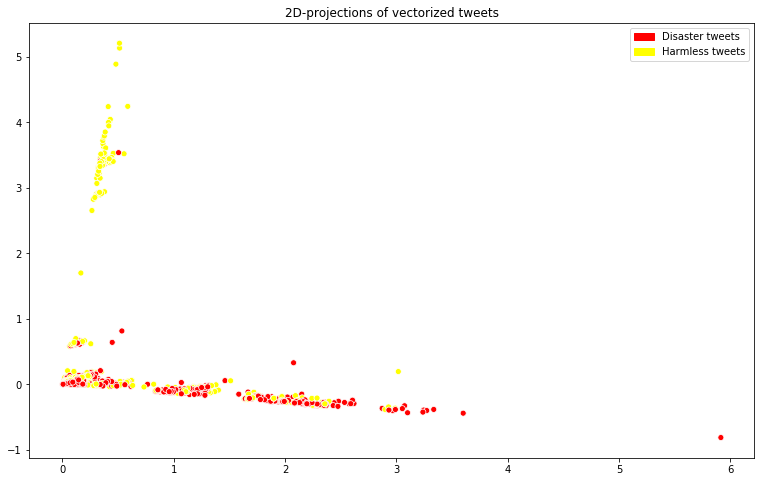

In [88]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches

plt.figure(figsize=(13,8))
svd = TruncatedSVD(n_components=2)
projected_train_vectors = svd.fit_transform(train_vectors)
sns.scatterplot(x=projected_train_vectors[:,0], y=projected_train_vectors[:,1], hue=y, palette={0:'yellow', 1:'red'}, legend=False)
red_patch = mpatches.Patch(color='red', label='Disaster tweets')
yellow_patch = mpatches.Patch(color='yellow', label='Harmless tweets')
plt.legend(handles=[red_patch, yellow_patch])
plt.title('2D-projections of vectorized tweets');

Now we test several classifiers and see which one performs best.  We do a grid search to tweak some hyperparameters. Performance in the competition is evaluated by F1-score.

In [89]:
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

models = {'k-nearest neighbors': KNeighborsClassifier(), 'random forest':RandomForestClassifier(), 'stochastic gradient descent': SGDClassifier()}

model_parameters = {
'k-nearest neighbors': {'n_neighbors': [3,5,7], 
                         'weights': ['uniform', 'distance']},
 'random forest': {'n_estimators':[50, 100], 
                    'min_samples_leaf': [5,10]}, 
'stochastic gradient descent' : {'loss': ['hinge', 'log', 'perceptron'], 
                   'penalty': ['l1', 'l2'], 
                   'learning_rate': ['constant', 'optimal', 'adaptive'],
                  'eta0': [0.005, 0.01]}
}

f1_scorer = make_scorer(f1_score)
max_score = 0


for model in models.keys():
    grid_search = GridSearchCV(models[model], model_parameters[model], scoring=f1_scorer, verbose=0, cv=5)
    grid_search.fit(X_train, y_train)
    clf = grid_search.best_estimator_
    training_score = f1_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_val)
    validation_score = f1_score(y_pred, y_val)
    if validation_score > max_score:
        best_clf = clf
        max_score = validation_score
    print('Parameters of best {} classifier: {}'.format(model, grid_search.best_params_))    
    print('F1-score on training set: {}'.format(training_score ))
    print('F1-score on validation set: {}'.format(validation_score))

Parameters of best k-nearest neighbors classifier: {'n_neighbors': 3, 'weights': 'distance'}
F1-score on training set: 0.9997786141244188
F1-score on validation set: 0.49118387909319894


C:\Users\steff\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\steff\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Parameters of best random forest classifier: {'min_samples_leaf': 5, 'n_estimators': 50}
F1-score on training set: 0.6149271483794232
F1-score on validation set: 0.5412054120541205
Parameters of best stochastic gradient descent classifier: {'eta0': 0.005, 'learning_rate': 'optimal', 'loss': 'log', 'penalty': 'l2'}
F1-score on training set: 0.9982293050022134
F1-score on validation set: 0.7444976076555024


The kNN classifier is overfitting and logistic regression seems to do better than random forests. Let's take a look at the best classifier:

In [90]:
best_clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.005, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Finally, let's see how well the model performs on the test set.

In [92]:
from sklearn.metrics import accuracy_score

y_pred = best_clf.predict(test_vectors)
print('F1-score: {}%'.format(round(100*f1_score(y_test, y_pred),2)))
print('Accuracy score: {}%'.format(round(100*accuracy_score(y_test, y_pred),2)))


F1-score: 73.27%
Accuracy score: 78.98%
